In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

import numpy as np
import time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing.data import QuantileTransformer
from sklearn import model_selection

import plotly
plotly.offline.init_notebook_mode()

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set(font_scale=1.5)

# Data Preparation
First we ingested the Market Check Used Car Inventory data file containing used cars accross United States (~6.7 million instances with 38 features
Then we did initial data wraggling in SQLite and Alteryx (Removed columns with null values, single values, huge descriptive text values. Also instances with null values and 4 digit zipcodes

In [2]:
#df = pd.read_csv(r'C:\Downloads\car_data_clean_complete_v4.csv')
#df = pd.read_csv(r'C:\Users\yexin\Desktop\KBB\NewCarData_clean.csv')
df = pd.read_csv(r'C:/Users/Namrata/Desktop/GT/car_data_clean_complete_v4.csv')

In [3]:
df.head()

id             vin_ss  price_fs  \
0  026454b9-8f7f-4200-8a22-15505442b297  1GNKVLED4CJ261435     16342   
1  03decb32-0fac-45be-b5cb-abfffbbd25e8  JM3TB2CA1C0346156     12500   
2  07eaaaba-df00-4440-ad09-438a6ad2ec00  JTHBE5C20C5030562     21990   
3  09c33c55-0d16-483c-a86f-392cc48cac3e  2C3CCAAGXCH312420     11988   
4  09dafb80-659c-41f7-92a1-4933e7dcbb2c  4T4BF1FK3CR169613     13990   

   miles_fs stock_no_ss  year_is    make_ss  model_ss  trim_ss  \
0     71233     P261435     2012  Chevrolet  Traverse      LTZ   
1    100215    DT11444A     2012      Mazda      CX-9  Touring   
2     44637     180770A     2012      Lexus    IS 350     Base   
3     94012      P10436     2012   Chrysler       300     Base   
4     86122      762911     2012     Toyota     Camry        L   

  vehicle_type_ss   ...    irs_estimated_population_2015    county full  \
0             SUV   ...                             5210  Platte County   
1             SUV   ...                             5210  Platte County   
2             Car   ...                             5210  Platte County   
3             Car   ...                             5210  Platte County   
4             Car   ...                             5210  Platte County   

  State short  Per Capita income Median Household income  \
0          MO         $35,143.00              $67,721.00   
1          MO         $35,143.00              $67,721.00   
2          MO         $35,143.00              $67,721.00   
3          MO         $35,143.00              $67,721.00   
4          MO         $35,143.00              $67,721.00   

   Median Family income  Population Number of households State full  Regions  
0            $83,110.00       90842                36781   Missouri  MidWest  
1            $83,110.00       90842                36781   Missouri  MidWest  
2            $83,110.00       90842                36781   Missouri  MidWest  
3            $83,110.00       90842                36781   Missouri  MidWest  
4            $83,110.00       90842                36781   Missouri  MidWest  

[5 rows x 49 columns]

In [5]:
print(df.shape)

(1673470, 49)


In [6]:
df.isnull().sum()

id                               0
vin_ss                           0
price_fs                         0
miles_fs                         0
stock_no_ss                      0
year_is                          0
make_ss                          0
model_ss                         0
trim_ss                          0
vehicle_type_ss                  0
body_type_ss                     0
drivetrain_ss                    0
engine_ss                        0
engine_size_ss                   0
transmission_ss                  0
doors_is                         0
cylinders_is                     0
interior_color_ss                0
exterior_color_ss                0
dom_is                           0
dom_180_is                       0
msrp_fs                          0
dom_active_is                    0
is_certified_is                  0
fuel_type_ss                     0
scraped_at_dts                   0
status_date_dts                  0
city_ss                          0
state_ss            

In [7]:
df = df.rename(index=str, columns={"vin_ss": "vin", "price_fs": "price", "miles_fs": "miles", "year_is": "year", "make_ss": "make", "model_ss": "model", "trim_ss": "trim", "vehicle_type_ss": "vehicle_type", "body_type_ss": "body_type", "drivetrain_ss": "drivetrain", "engine_ss":"engine", "engine_size_ss": "engine_size", "transmission_ss": "transmission", "doors_is": "doors", "cylinders_is": "cylinders", "interior_color_ss": "interior_color", "exterior_color_ss": "exterior_color", "zip_is": "zip", "dom_is": "dom", "dom_180_is": "dom_180", "msrp_fs": "msrp", "dom_active_is": "dom_active", "is_certified_is": "is_certified", "fuel_type_ss": "fuel_type", "scraped_at_dts": "scraped_at", "status_date_dts": "status_date", "stock_no_ss": "stock_no"})
df = df.drop(columns=['city_ss', 'state_ss'])
df.columns

Index(['id', 'vin', 'price', 'miles', 'stock_no', 'year', 'make', 'model',
       'trim', 'vehicle_type', 'body_type', 'drivetrain', 'engine',
       'engine_size', 'transmission', 'doors', 'cylinders', 'interior_color',
       'exterior_color', 'dom', 'dom_180', 'msrp', 'dom_active',
       'is_certified', 'fuel_type', 'scraped_at', 'status_date', 'AGE', 'zip',
       'type', 'decommissioned', 'primary_city', 'state', 'county', 'timezone',
       'latitude', 'longitude', 'irs_estimated_population_2015', 'county full',
       'State short', 'Per Capita income', 'Median Household income',
       'Median Family income', 'Population', 'Number of households',
       'State full', 'Regions'],
      dtype='object')

In [8]:
df.shape

(1673470, 47)

In [9]:
df['Median Household income num'] = (df['Median Household income'].replace ( '[\$,)]','', regex=True )
                                    .replace( '[(]','-',   regex=True ).astype(float))

In [10]:
df.shape

(1673470, 48)

In [11]:
df["make"].value_counts().sort_values(ascending=False)

Chevrolet        223536
Ford             212925
Toyota           144307
Nissan           125830
Honda            110104
Jeep              94594
Hyundai           70915
BMW               64845
GMC               64358
Lexus             62912
Dodge             57004
Kia               51036
Ram               45052
Mercedes-Benz     42013
Volkswagen        39268
Acura             30778
Subaru            30637
Mazda             30367
Cadillac          29398
Buick             28046
Chrysler          22509
Audi              20607
INFINITI          19198
Lincoln           14161
Land Rover        11309
MINI              10370
Volvo              8875
Porsche            8516
Name: make, dtype: int64

In [12]:
df = df.drop(df[df["make"] == "Panoz"].index | df[df["make"] == "Daewoo"].index | df[df["make"] == "Maybach"].index | df[df["make"] == "AM General"].index | df[df["make"] == "Geo"].index | df[df["make"] == "Fisker"].index | df[df["make"] == "Alfa Romeo"].index | df[df["make"] == "Lotus"].index | df[df["make"] == "McLaren"].index | df[df["make"] == "Plymouth"].index | df[df["make"] == "Isuzu"].index | df[df["make"] == "Oldsmobile"].index | df[df["make"] == "Lamborghini"].index | df[df["make"] == "Rolls-Royce"].index | df[df["make"] == "Aston Martin"].index | df[df["make"] == "Saab"].index | df[df["make"] == "smart"].index | df[df["make"] == "Suzuki"].index | df[df["make"] == "Infiniti"].index | df[df["make"] == "Ferrari"].index | df[df["make"] == "Bentley"].index | df[df["make"] == "Maserati"].index | df[df["make"] == "HUMMER"].index | df[df["make"] == "Mercury"].index | df[df["make"] == "Saturn"].index | df[df["make"] == "FIAT"].index | df[df["make"] == "Pontiac"].index | df[df["make"] == "Jaguar"].index | df[df["make"] == "Scion"].index | df[df["make"] == "Mitsubishi"].index | df[df["make"] == "Porsche"].index | df[df["make"] == "Volvo"].index | df[df["make"] == "MINI"].index | df[df["make"] == "Land Rover"].index | df[df["make"] == "Lincoln"].index | df[df["make"] == "Fiat"].index)
expcars = (df['price'] > 5000) & (df['price'] < 50000)
df = df[expcars]

In [13]:
df.shape

(1569646, 48)

In [14]:
df = df.drop_duplicates(['price', 'miles', 'year', 'make', 'model', 'trim', 
       'engine_size',  'cylinders', 'interior_color', 
       'exterior_color', 'zip', 'msrp', 'is_certified', 'fuel_type', 'state', 
                     'AGE', 'Regions', 'Population', 'Median Household income num'])

In [15]:
df.shape

(1300219, 48)

## Visualizations Begin

In [16]:
statesmean = pd.DataFrame(df.groupby('state').mean())
statesmean = statesmean.reset_index()

#scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
#            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]
scl = [[0.0, 'rgb(0,255,0)'],[0.2, 'rgb(102,255,0)'],[0.4, 'rgb(204,255,0)'],\
            [0.6, 'rgb(255,204,0)'],[0.8, 'rgb(255,102,0)'],[1.0, 'rgb(255,0,0)']]

def us_map(z, scl, title, colorlabel):
    
    #This chunk allows you to apply labels to states, don't need it at the moment.
    #df['text'] = df['state'] + '<br>' +\
    #    'Beef '+df['beef']+' Dairy '+df['dairy']+'<br>'+\
    #    'Fruits '+df['total fruits']+' Veggies ' + df['total veggies']+'<br>'+\
    #    'Wheat '+df['wheat']+' Corn '+df['corn']
    
    data =[ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = statesmean['state'],
        z = z, 
        locationmode = 'USA-states',
        #text = df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = colorlabel)
        ) ]
    
    layout = dict(
        title = title,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
        
    fig = dict( data=data, layout=layout )
    plotly.offline.iplot(fig, filename='d3-cloropleth-map')
    
us_map(statesmean['price'], scl, title="Mean Used Vehicle Prices in the US", colorlabel="USD")

C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



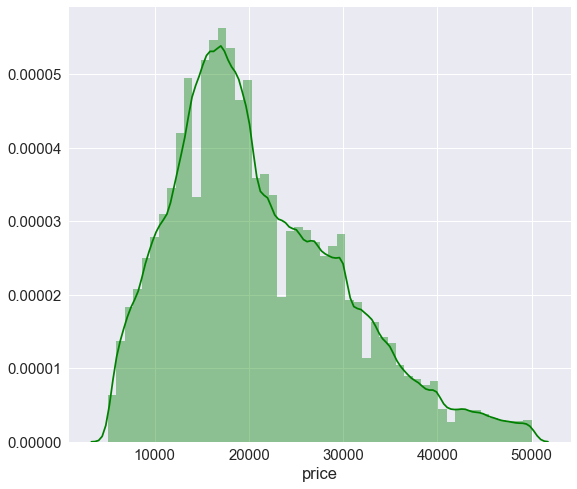

In [17]:
# so  now the car price distribution looks more even
plt.figure(figsize=(9, 8))
sns.distplot(df['price'], color='g', bins=50)

Most Popular used car makes are Chevrolet and Ford

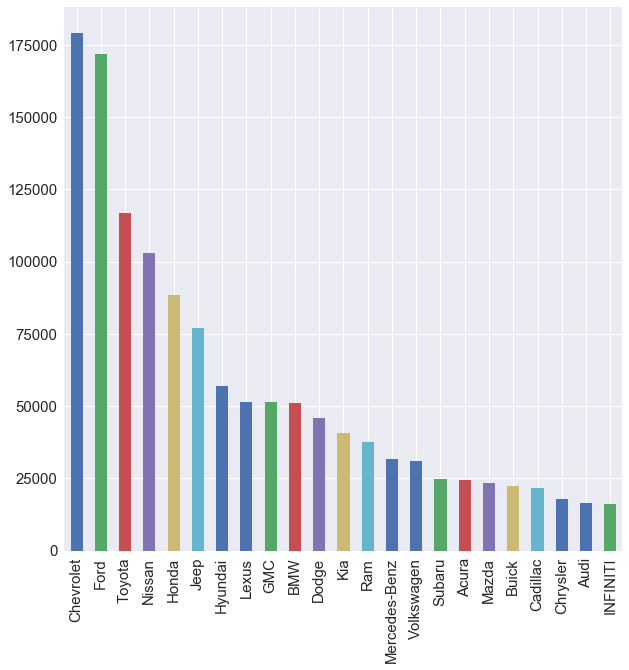

In [27]:
df['make'].value_counts().plot(kind='bar', figsize=(10,10))

Newer cars are more expensive than older cars. Expected.

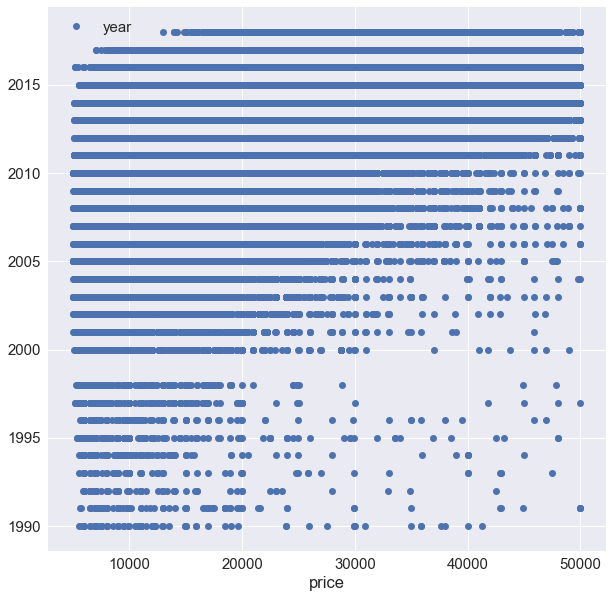

In [28]:
df.plot(x='price', y='year', style='o', figsize=(10,10))

Range and median prices per car type

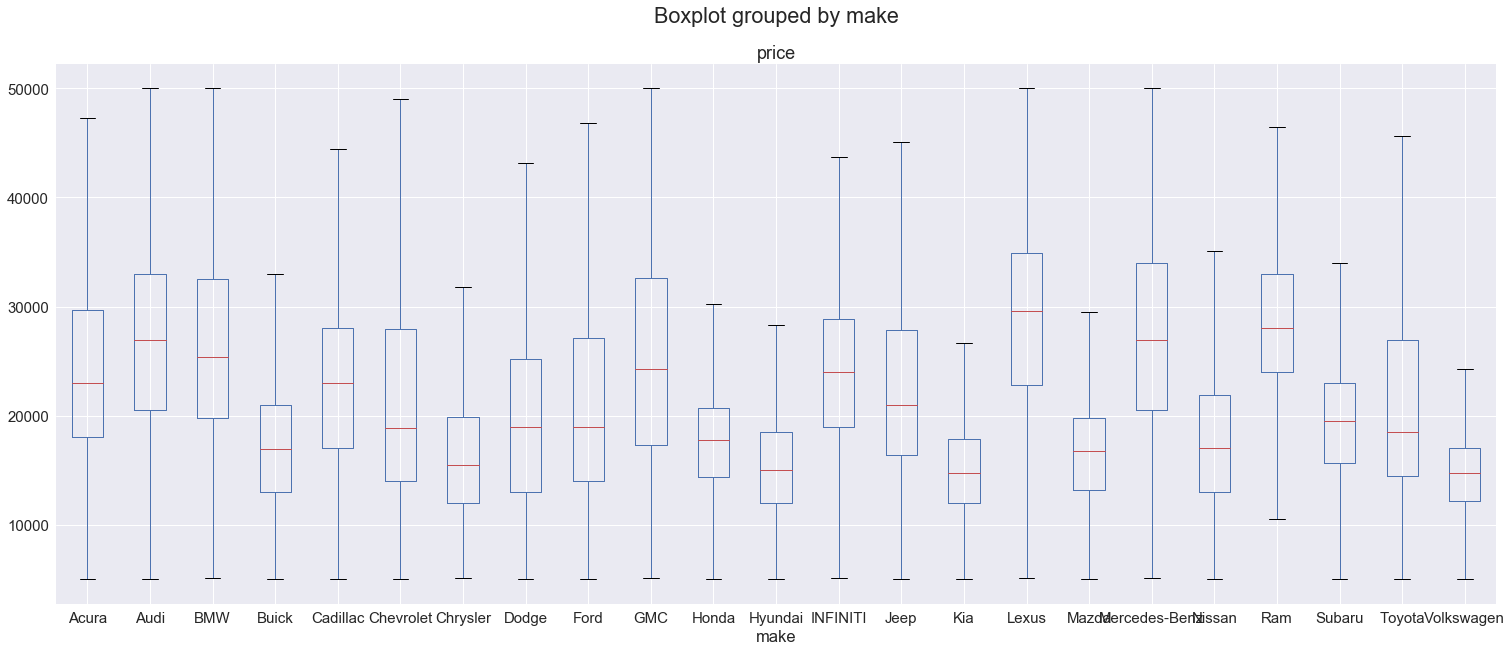

In [29]:
df.boxplot(column="price", by="make", figsize=(25,10), showfliers=False)

# Feature Engineering

Converting categorical features into numeric values using Scikit Learn

In [18]:
labels = ['make', 'model', 'trim', 'interior_color', 'exterior_color', 'zip', 'fuel_type', 
          'State short', 'Regions','stock_no', 'vehicle_type', 'body_type', 'drivetrain', 'engine', 'transmission']
les = {}

for l in labels:
    les[l] = LabelEncoder()
    les[l].fit(df[l].astype(str))
    tr = les[l].transform(df[l].astype(str))
    
    df.loc[:, l + '_feat'] = pd.Series(tr, index=df.index)

labeled = df[['price'
                        ,'miles'
                        ,'year'
                        ,'cylinders'
                        ,'msrp'
                        , 'is_certified'
                        , 'engine_size'
                        ,'AGE', 'Population', 'doors', 'dom', 'dom_180', 'dom_active', 
                         'Median Household income num'] 
                    + [x+"_feat" for x in labels]]

In [31]:
print(labeled.head())

   price   miles  year  cylinders   msrp  is_certified  engine_size  AGE  \
0  16342   71233  2012          6  16342             0        3.600    7   
1  12500  100215  2012          6  12500             0        3.700    7   
2  21990   44637  2012          6  21990             1        3.500    7   
3  11988   94012  2012          6  11988             0        3.600    7   
4  13990   86122  2012          4  13990             0        2.500    7   

   Population  doors        ...          zip_feat  fuel_type_feat  \
0       90842      4        ...              4608               6   
1       90842      4        ...              4608               6   
2       90842      4        ...              4608               5   
3       90842      4        ...              4608               2   
4       90842      4        ...              4608               6   

   State short_feat  Regions_feat  stock_no_feat  vehicle_type_feat  \
0                21             0         434710         

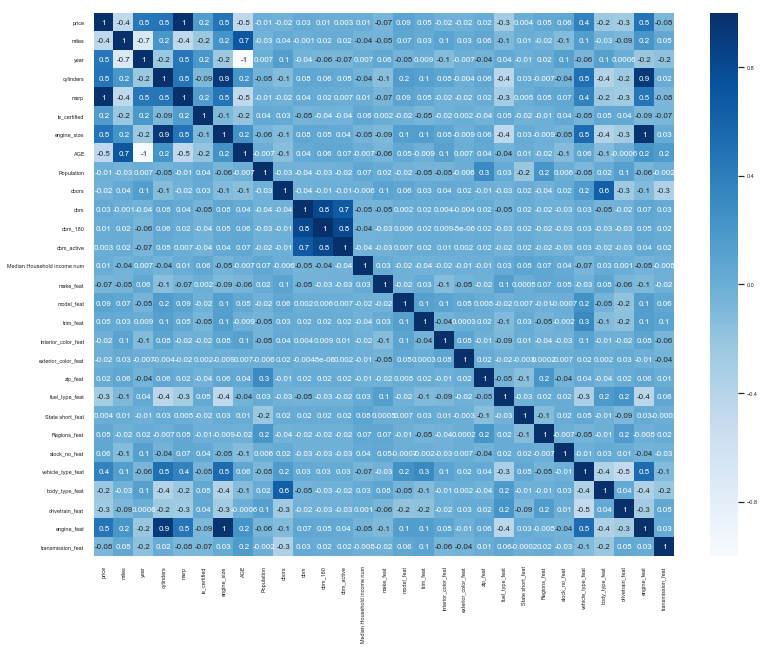

In [17]:
corr = labeled.corr(method='pearson')
sns.set(font_scale=0.5)
f, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(corr, annot = True, fmt =".1g", annot_kws={"size": 8}, cmap = "Blues")

In [18]:
labeled.corr().loc[:,'price'].abs().sort_values(ascending=False)[1:]

msrp                          0.990
engine_size                   0.475
engine_feat                   0.474
cylinders                     0.473
AGE                           0.453
year                          0.453
miles                         0.448
vehicle_type_feat             0.371
fuel_type_feat                0.286
drivetrain_feat               0.262
body_type_feat                0.240
is_certified                  0.163
model_feat                    0.094
transmission_feat             0.082
make_feat                     0.067
stock_no_feat                 0.064
Regions_feat                  0.052
trim_feat                     0.046
dom                           0.034
doors                         0.024
exterior_color_feat           0.021
interior_color_feat           0.019
zip_feat                      0.019
Population                    0.015
dom_180                       0.014
Median Household income num   0.012
State short_feat              0.004
dom_active                  

# Model Selection 
Used 25 most influencing features to predict price (80/20 train test split)
Dropped msrp_fs because of 1:1 corelation with price_fs; dropped year_is as it is duplicate with AGE; dropped engine_feat similar to engine

# Model 1 Linear Regression 

In [19]:
y = labeled.price

In [20]:
print (labeled.columns.tolist())

['price', 'miles', 'year', 'cylinders', 'msrp', 'is_certified', 'engine_size', 'AGE', 'Population', 'doors', 'dom', 'dom_180', 'dom_active', 'Median Household income num', 'make_feat', 'model_feat', 'trim_feat', 'interior_color_feat', 'exterior_color_feat', 'zip_feat', 'fuel_type_feat', 'State short_feat', 'Regions_feat', 'stock_no_feat', 'vehicle_type_feat', 'body_type_feat', 'drivetrain_feat', 'engine_feat', 'transmission_feat']


In [21]:
X = labeled[['miles', 'cylinders', 'is_certified', 'engine_size', 'AGE', 'Population', 'doors', 
             'dom', 'dom_180', 'dom_active', 'Median Household income num', 'make_feat', 'model_feat', 'trim_feat', 
             'interior_color_feat', 'exterior_color_feat', 'zip_feat', 'fuel_type_feat', 'State short_feat', 
             'Regions_feat', 'stock_no_feat', 'vehicle_type_feat', 'body_type_feat', 'drivetrain_feat', 
              'transmission_feat']]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
reg = LinearRegression()

In [37]:
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [38]:
y_pred = reg.predict(X_test)

In [39]:
r2= r2_score(y_pred, y_test)
print(r2)

0.5157442205286966


In [40]:
mean_squared_error(y_pred, y_test)

26949053.60841656

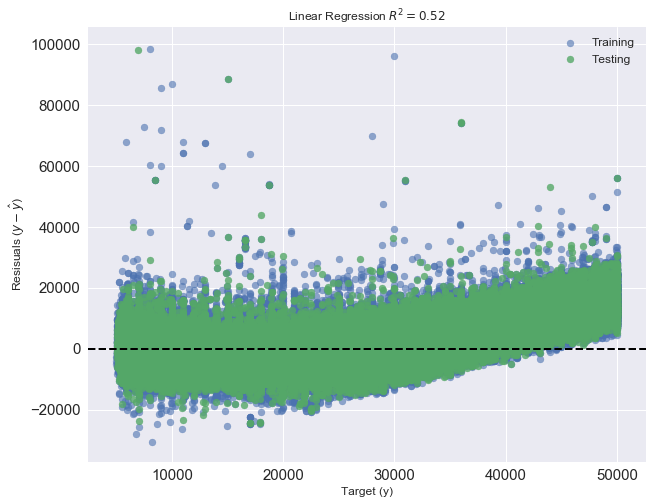

In [42]:
#Compute Residuals
test_residuals = y_test - y_pred
train_residuals = y_train - reg.predict(X_train)

#Draw residuals
fig, ax = plt.subplots(figsize= (10,8))
ax.scatter(y_train, train_residuals, label="Training", alpha=0.6)
ax.scatter(y_test, test_residuals, label="Testing", alpha=0.8)

#Make plot pretty
ax.set_title("Linear Regression $R^2={:0.2f}$".format(r2), fontsize=12)
ax.legend(loc='best', fontsize=12)
ax.set_ylabel("Resisuals ($y-\hat{y}$)", fontsize=12)
ax.set_xlabel("Target (y)", fontsize=12)

#Draw zero line
ax.axhline(0, c='k', ls='--', lw=2)

In [43]:
from sklearn import cross_validation
cv = cross_validation.KFold(len(y_pred), n_folds=12,  random_state=30)

In [43]:
print(cv)

sklearn.cross_validation.KFold(n=260044, n_folds=12, shuffle=False, random_state=30)


In [44]:
from yellowbrick.model_selection import CVScores
from sklearn.model_selection import StratifiedKFold

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=12.



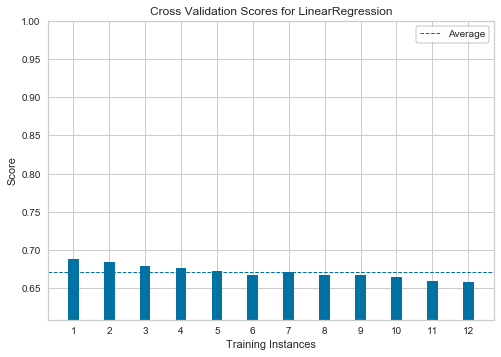

In [45]:
# Create a new figure and axes
_, ax = plt.subplots()

# Create a cross-validation strategy
cv = StratifiedKFold(12)

# Create the cv score visualizer
oz = CVScores(
    LinearRegression(), ax=ax, cv=cv, scoring='r2'
)

oz.fit(X, y)
oz.poof()

# Model 2 - Decision Tree (Random Forest Regressor)

In [33]:
rf = RandomForestRegressor()

In [34]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [35]:
y_pred = rf.predict(X_test)

In [36]:
r2 = r2_score(y_pred, y_test)
print(r2)

0.970752296588402


In [37]:
mean_squared_error(y_pred, y_test)

2339588.661835726

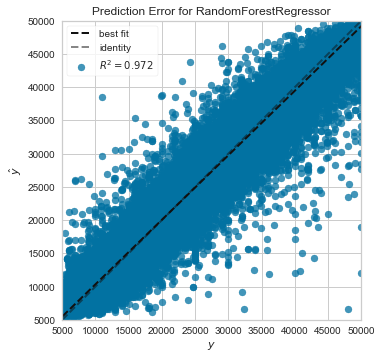

In [38]:
from yellowbrick.regressor import PredictionError

# Instantiate the linear model and visualizer
visualizer = PredictionError(rf)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

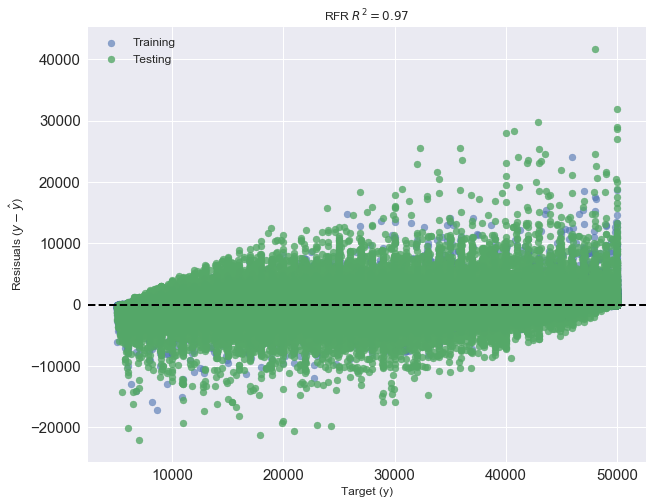

In [50]:
#Compute Residuals
test_residuals = y_test - y_pred
train_residuals = y_train - rf.predict(X_train)

#Draw residuals
fig, ax = plt.subplots(figsize= (10,8))
ax.scatter(y_train, train_residuals, label="Training", alpha=0.6)
ax.scatter(y_test, test_residuals, label="Testing", alpha=0.8)

#Make plot pretty
ax.set_title("RFR $R^2={:0.2f}$".format(r2), fontsize=12)
ax.legend(loc='best', fontsize=12)
ax.set_ylabel("Resisuals ($y-\hat{y}$)", fontsize=12)
ax.set_xlabel("Target (y)", fontsize=12)

#Draw zero line
ax.axhline(0, c='k', ls='--', lw=2)

(array([6.10000e+01, 8.20000e+01, 1.15000e+02, 1.43000e+02, 2.76000e+02,
        3.68000e+02, 5.68000e+02, 8.65000e+02, 1.27300e+03, 2.16200e+03,
        3.48900e+03, 6.01900e+03, 1.04620e+04, 2.01880e+04, 5.40760e+04,
        1.06669e+05, 2.44260e+04, 1.25890e+04, 6.83800e+03, 3.73700e+03,
        2.04500e+03, 1.21800e+03, 7.46000e+02, 4.65000e+02, 3.20000e+02,
        1.80000e+02, 1.14000e+02, 6.40000e+01, 5.60000e+01, 4.60000e+01]),
 array([-9.99890000e+03, -9.33275333e+03, -8.66660667e+03, -8.00046000e+03,
        -7.33431333e+03, -6.66816667e+03, -6.00202000e+03, -5.33587333e+03,
        -4.66972667e+03, -4.00358000e+03, -3.33743333e+03, -2.67128667e+03,
        -2.00514000e+03, -1.33899333e+03, -6.72846667e+02, -6.70000000e+00,
         6.59446667e+02,  1.32559333e+03,  1.99174000e+03,  2.65788667e+03,
         3.32403333e+03,  3.99018000e+03,  4.65632667e+03,  5.32247333e+03,
         5.98862000e+03,  6.65476667e+03,  7.32091333e+03,  7.98706000e+03,
         8.65320667e+03,  9.

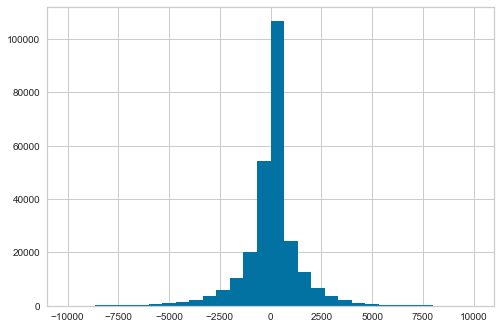

In [52]:
subsetted_data_pred = y_pred[y_test < 60000]
subsetted_data_test = y_test[y_test < 60000]

differences = subsetted_data_pred - subsetted_data_test
d = differences[(differences < 10000) & (differences > -10000)]

plt.hist(d,bins=30)

In [53]:
d.mean(), d.std()

(29.282010604360693, 1417.7418581395177)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=12.



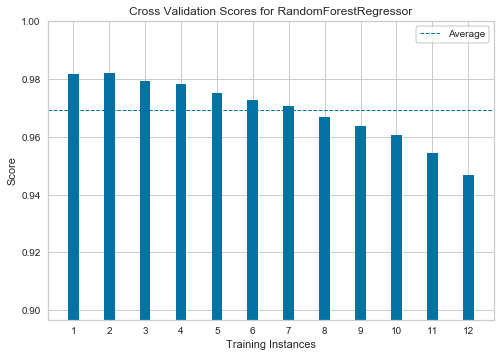

In [54]:
# Create a new figure and axes
_, ax = plt.subplots()

# Create a cross-validation strategy
cv = StratifiedKFold(12)

# Create the cv score visualizer
oz = CVScores(
    RandomForestRegressor(), ax=ax, cv=cv, scoring='r2'
)

oz.fit(X, y)
oz.poof()

# Model 3 - Decision Tree Gradient Boost

In [51]:
gbr = GradientBoostingRegressor()

In [52]:
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [53]:
y_pred = gbr.predict(X_test)

In [54]:
r2 = r2_score(y_pred, y_test)
print(r2)

0.8125462074933149


In [55]:
mean_squared_error(y_pred, y_test)

11908696.52886898

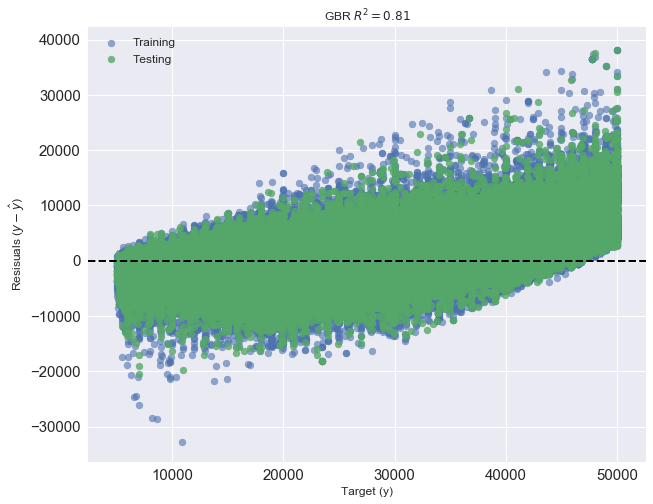

In [56]:
#Compute Residuals
test_residuals = y_test - y_pred
train_residuals = y_train - gbr.predict(X_train)

#Draw residuals
fig, ax = plt.subplots(figsize= (10,8))
ax.scatter(y_train, train_residuals, label="Training", alpha=0.6)
ax.scatter(y_test, test_residuals, label="Testing", alpha=0.8)

#Make plot pretty
ax.set_title("GBR $R^2={:0.2f}$".format(r2), fontsize=12)
ax.legend(loc='best', fontsize=12)
ax.set_ylabel("Resisuals ($y-\hat{y}$)", fontsize=12)
ax.set_xlabel("Target (y)", fontsize=12)

#Draw zero line
ax.axhline(0, c='k', ls='--', lw=2)

(array([  771.,  1076.,  1314.,  1617.,  1957.,  2833.,  3482.,  4503.,
         5850.,  8017., 10342., 13654., 17087., 21092., 24399., 26082.,
        24904., 21877., 17714., 13754., 10182.,  7405.,  5304.,  3737.,
         2436.,  1758.,  1333.,   881.,   524.,   333.]),
 array([-9.99491069e+03, -9.32843210e+03, -8.66195350e+03, -7.99547490e+03,
        -7.32899631e+03, -6.66251771e+03, -5.99603912e+03, -5.32956052e+03,
        -4.66308192e+03, -3.99660333e+03, -3.33012473e+03, -2.66364613e+03,
        -1.99716754e+03, -1.33068894e+03, -6.64210344e+02,  2.26825183e+00,
         6.68746848e+02,  1.33522544e+03,  2.00170404e+03,  2.66818264e+03,
         3.33466123e+03,  4.00113983e+03,  4.66761843e+03,  5.33409702e+03,
         6.00057562e+03,  6.66705422e+03,  7.33353281e+03,  8.00001141e+03,
         8.66649000e+03,  9.33296860e+03,  9.99944720e+03]),
 <a list of 30 Patch objects>)

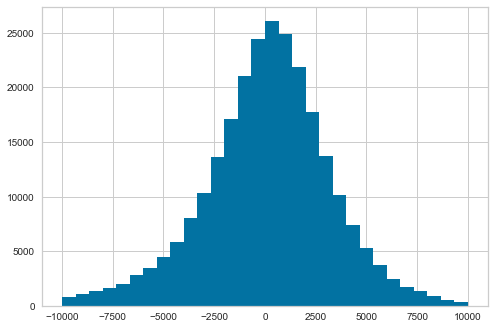

In [62]:
subsetted_data_pred = y_pred[y_test < 60000]
subsetted_data_test = y_test[y_test < 60000]

differences = subsetted_data_pred - subsetted_data_test
d = differences[(differences < 10000) & (differences > -10000)]

plt.hist(d,bins=30)

In [63]:
d.mean(), d.std()

(131.48225516094757, 3096.817144426237)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=12.



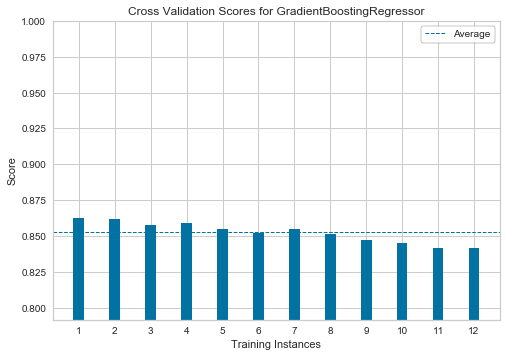

In [64]:
# Create a new figure and axes
_, ax = plt.subplots()

# Create a cross-validation strategy
cv = StratifiedKFold(12)

# Create the cv score visualizer
oz = CVScores(
    GradientBoostingRegressor(), ax=ax, cv=cv, scoring='r2'
)

oz.fit(X, y)
oz.poof()

LR
CV accuracy: 0.66447 +/- 0.00204
--- 200.77916049957275 seconds ---
RFR
CV accuracy: 0.97128 +/- 0.00049
--- 3262.2842495441437 seconds ---
GBR
CV accuracy: 0.85478 +/- 0.00128
--- 4268.505824804306 seconds ---


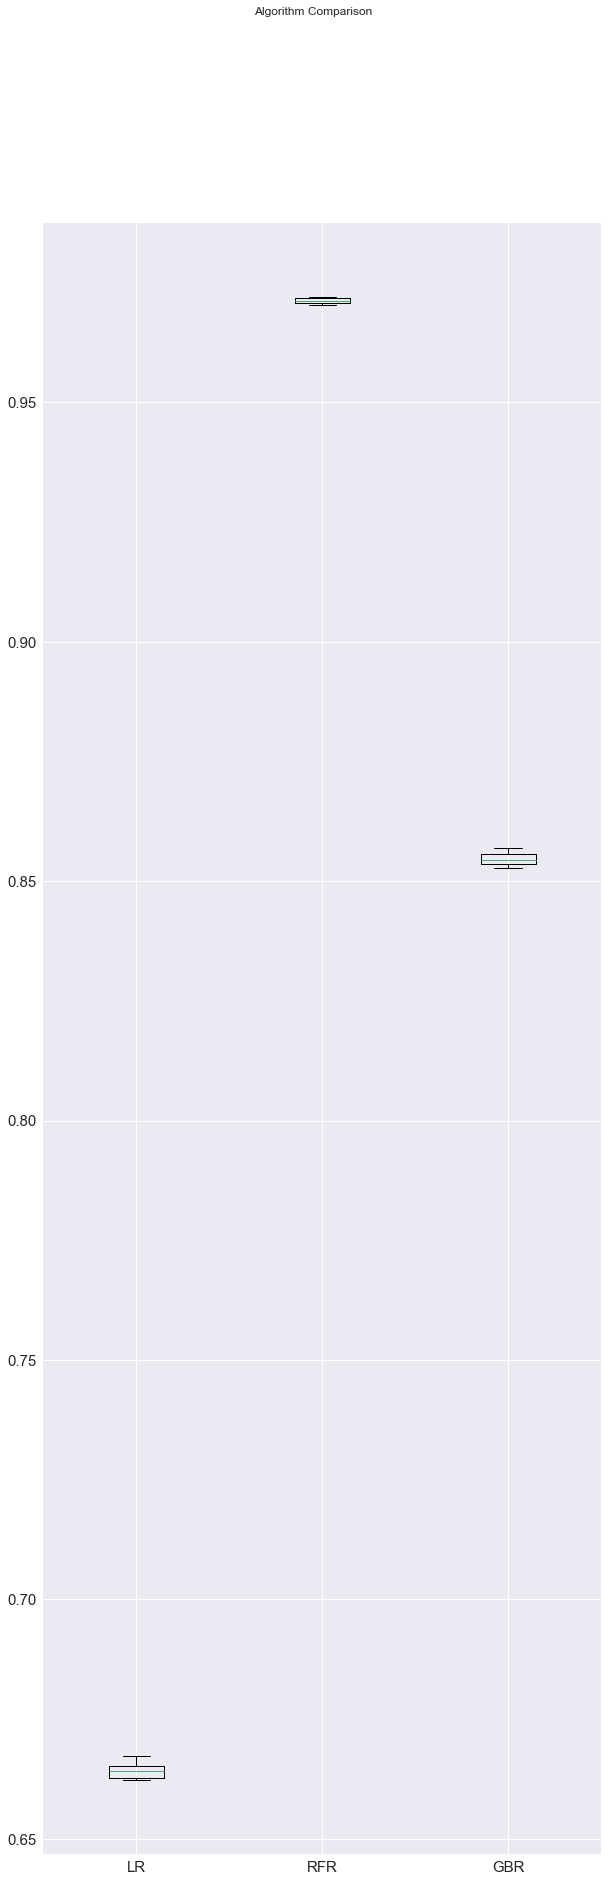

In [23]:
# Comparing Algorithms

models = []
models.append(('LR', LinearRegression()))
models.append(('RFR', RandomForestRegressor()))
models.append(('GBR', GradientBoostingRegressor()))

scoring = 'r2'

results = []
names = []

from sklearn.model_selection import cross_val_score
res_scores = []
m_names = []
for name, model in models:
    start_time = time.time()
    print(name)
    pipe_mdl = make_pipeline(QuantileTransformer(),
                        model)
    kfold = model_selection.KFold(n_splits=12, random_state=7)
    scores = model_selection.cross_val_score(estimator=pipe_mdl,
                         X=X_train,
                         y=y_train,
                         cv=kfold,
                         #n_jobs=-1,
                         scoring = scoring)
    print('CV accuracy: %.5f +/- %.5f' % (np.mean(scores),np.std(scores)))
    res_scores.append(scores)
    m_names.append(name)
    print('--- %s seconds ---' % (time.time() - start_time))

fig = plt.figure(figsize=(10, 30))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(res_scores)
ax.set_xticklabels(m_names, fontsize=12)
plt.show()

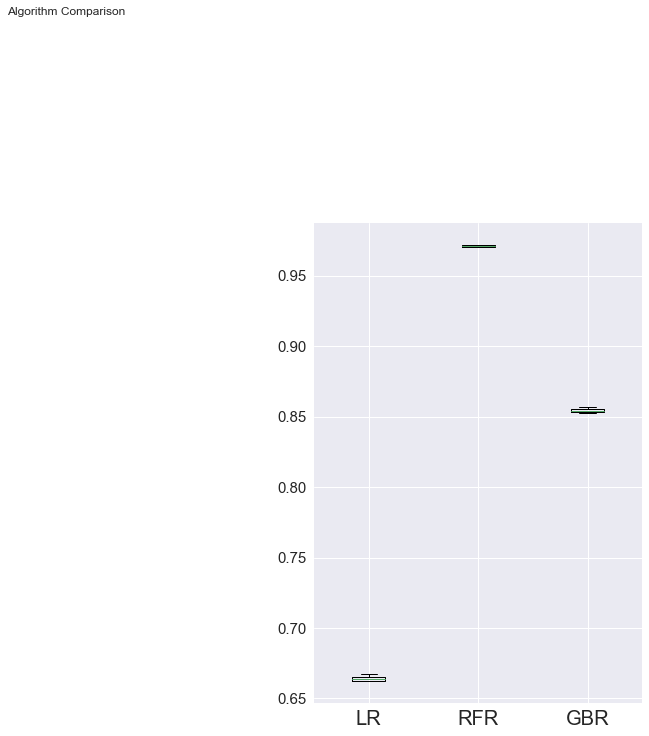

In [31]:
fig = plt.figure(figsize=(20, 30))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(333)
plt.boxplot(res_scores)
ax.set_xticklabels(m_names, fontsize=20)
plt.show()

In [32]:
from yellowbrick.regressor import PredictionError

# Instantiate the linear model and visualizer
rfr = randomforestregressor()
visualizer = PredictionError(rfr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

NameError: name 'randomforestregressor' is not defined

# Model 4 - LASSO (L1 Regularization)
LASSO forces weak features to have zeroes as coefficients, effectively dropping the least predictive features

In [72]:
clf_lasso = linear_model.Lasso(alpha=0.5)

In [73]:
clf_lasso.fit(X_train, y_train)

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [75]:
y_pred = clf_lasso.predict(X_test)

In [76]:
print(list(zip(X, clf_lasso.coef_.tolist())))

[('miles_fs', -0.07614534346539392), ('cylinders_is', 1980.536992578208), ('is_certified_is', 1900.4918390046741), ('engine_size_ss', 2601.735936687575), ('AGE', -1185.8244889186951), ('Population', -9.129081656262214e-05), ('make_ss_feat', -55.069952158012114), ('model_ss_feat', 1.5798711962839496), ('trim_ss_feat', 0.023787372155289897), ('interior_color_ss_feat', -0.0590021151847937), ('exterior_color_ss_feat', -0.06350493157594933), ('zip_is_feat', 0.03555701418238278), ('fuel_type_ss_feat', -76.5544531169513), ('state_ss_feat', 0.4200247280548342), ('Regions_feat', 398.8258993610262)]


In [77]:
r2_score(y_pred, y_test)

0.5354522227192369

In [78]:
mean_squared_error(y_pred, y_test)

26679329.006395474

# Model 5 - Ridge Regression (L2 Regularization)
Ridge assigns every feature a weight, but spreads the coefficient values out more equally, shrinking but still maintaining less predictive features.

In [79]:
clf = linear_model.Ridge(alpha=0.5)

In [80]:
clf.fit(X_train, y_train)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [81]:
y_pred = clf.predict(X_test)

In [82]:
print(list(zip(X, clf.coef_.tolist())))

[('miles_fs', -0.07613388510978458), ('cylinders_is', 1980.308101651942), ('is_certified_is', 1905.0513909458634), ('engine_size_ss', 2602.3061167777373), ('AGE', -1185.9200650311266), ('Population', -9.136720738417963e-05), ('make_ss_feat', -55.11420097220476), ('model_ss_feat', 1.5791485210039014), ('trim_ss_feat', 0.02408988013257544), ('interior_color_ss_feat', -0.059009739630399016), ('exterior_color_ss_feat', -0.06351731529179516), ('zip_is_feat', 0.03552464549175999), ('fuel_type_ss_feat', -76.64450430985238), ('state_ss_feat', 0.42727423815379617), ('Regions_feat', 399.41305625980993)]


In [ ]:
r2_score(y_pred, y_test)

In [50]:
mean_squared_error(y_pred, y_test)

26679294.832889743

# Model 6 - Elastic Net
ElasticNet is a linear combination of L1 and L2 regularization, meaning it combines Ridge and LASSO and essentially splits the difference.

In [85]:
enr = linear_model.ElasticNet()

In [86]:
enr.fit(X_train, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [87]:
y_pred = enr.predict(X_test)

In [88]:
print(list(zip(X, enr.coef_.tolist())))

[('miles_fs', -0.08398239821169448), ('cylinders_is', 1950.1962706154782), ('is_certified_is', 349.9610019352311), ('engine_size_ss', 1791.2143386513092), ('AGE', -1002.5472075492388), ('Population', -9.649199068098547e-05), ('make_ss_feat', -54.43755889115906), ('model_ss_feat', 4.034231054735961), ('trim_ss_feat', 0.07136315498012737), ('interior_color_ss_feat', -0.05254176750680842), ('exterior_color_ss_feat', -0.06000848186510184), ('zip_is_feat', 0.05873174149221815), ('fuel_type_ss_feat', -317.5529832208474), ('state_ss_feat', -0.4207942610264381), ('Regions_feat', 269.0060936933721)]


In [89]:
r2_score(y_pred, y_test)

0.42124284889367447

In [90]:
mean_squared_error(y_pred, y_test)

27790896.317409452

# Model 7 Instance Based - KNearest Regressor

In [65]:
 model = KNeighborsRegressor(n_neighbors = 5)

In [66]:
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [67]:
y_pred = model.predict(X_test)

In [68]:
r2_score(y_pred, y_test)

-0.6314312959628026

In [69]:
mean_squared_error(y_pred, y_test)

64878370.72610711

# Feature Selection

In [23]:
y = labeled['price']

In [24]:
features= labeled[['miles', 'cylinders', 'is_certified', 'engine_size', 'AGE', 'Population', 'doors', 
             'dom', 'dom_180', 'dom_active', 'Median Household income num', 'make_feat', 'model_feat', 'trim_feat', 
             'interior_color_feat', 'exterior_color_feat', 'zip_feat', 'fuel_type_feat', 'State short_feat', 
             'Regions_feat', 'stock_no_feat', 'vehicle_type_feat', 'body_type_feat', 'drivetrain_feat', 
              'transmission_feat']]

### Lasso (L1 Regularization)

In [25]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
model = Lasso(alpha = 0.001)
model.fit(features, y)
print(list(zip(features, model.coef_.tolist())))

[('miles', -0.07788349095526988), ('cylinders', 1293.5787860183098), ('is_certified', 2060.2193945034437), ('engine_size', 2325.120830360108), ('AGE', -1132.9984599771599), ('Population', 2.207907737266735e-06), ('doors', -21.85749587798185), ('dom', -1.457476560768624), ('dom_180', 2.173863787489072), ('dom_active', -0.0021992036511578636), ('Median Household income num', 0.01447708605823093), ('make_feat', -66.7033718340787), ('model_feat', 1.2167519217817635), ('trim_feat', -1.8606462089260896), ('interior_color_feat', -0.029999939839114004), ('exterior_color_feat', -0.019741119956233486), ('zip_feat', 0.015145444537892511), ('fuel_type_feat', -231.26228925517822), ('State short_feat', -5.158203531767888), ('Regions_feat', 563.8368431707695), ('stock_no_feat', 0.0002810819308727922), ('vehicle_type_feat', 1011.758602079547), ('body_type_feat', -518.5580544583763), ('drivetrain_feat', -702.5473317361173), ('transmission_feat', -53.337669370322494)]


### Ridge Regression (L2 Regularization)

In [26]:
model = Ridge(alpha=0.001)
model.fit(features, y)
print(list(zip(features, model.coef_.tolist())))

[('miles', -0.07788345658853192), ('cylinders', 1293.578659390563), ('is_certified', 2060.228651389179), ('engine_size', 2325.120539486264), ('AGE', -1132.99876804636), ('Population', 2.207794151553969e-06), ('doors', -21.868356435743603), ('dom', -1.457476584268798), ('dom_180', 2.1738647880072435), ('dom_active', -0.0021990962400180595), ('Median Household income num', 0.014477075987047812), ('make_feat', -66.70336925452628), ('model_feat', 1.2167503771545374), ('trim_feat', -1.860646807758188), ('interior_color_feat', -0.029999948250520533), ('exterior_color_feat', -0.019741121716353335), ('zip_feat', 0.015145369468688595), ('fuel_type_feat', -231.26246017386796), ('State short_feat', -5.158201593063332), ('Regions_feat', 563.8381027963035), ('stock_no_feat', 0.00028108187115390414), ('vehicle_type_feat', 1011.7632033883976), ('body_type_feat', -518.5552569558004), ('drivetrain_feat', -702.5478883700347), ('transmission_feat', -53.33861219502951)]


### Transformer Methods ( SelectFromModel())

In [27]:
model = Lasso(alpha = 0.001)
sfm = SelectFromModel(model)
sfm.fit(features, y)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['miles', 'cylinders', 'is_certified', 'engine_size', 'AGE', 'doors', 'dom', 'dom_180', 'dom_active', 'Median Household income num', 'make_feat', 'model_feat', 'trim_feat', 'interior_color_feat', 'exterior_color_feat', 'zip_feat', 'fuel_type_feat', 'State short_feat', 'Regions_feat', 'stock_no_feat', 'vehicle_type_feat', 'body_type_feat', 'drivetrain_feat', 'transmission_feat']


In [28]:
model = Ridge(alpha=0.001)
sfm = SelectFromModel(model)
sfm.fit(features, y)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['cylinders', 'is_certified', 'engine_size', 'AGE', 'Regions_feat', 'vehicle_type_feat', 'body_type_feat', 'drivetrain_feat']


In [29]:
# Liner Regression
model= LinearRegression(normalize=True)
sfm = SelectFromModel(model)
sfm.fit(features, y.values.ravel())
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['cylinders', 'is_certified', 'engine_size', 'AGE', 'Regions_feat', 'vehicle_type_feat', 'body_type_feat', 'drivetrain_feat']


In [30]:
# RandomForestRegressor
model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
sfm = SelectFromModel(model)
sfm.fit(features, y.values.ravel())
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['miles', 'engine_size', 'AGE', 'trim_feat', 'fuel_type_feat']


In [31]:
#GradientBoostingRegressor
model = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
sfm = SelectFromModel(model)
sfm.fit(features, y.values.ravel())
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['miles', 'cylinders', 'engine_size', 'AGE', 'fuel_type_feat', 'drivetrain_feat']


### Visualizing Feature Importances

In [36]:
# feature importance of LinearRegression
X = labeled[['cylinders', 'is_certified', 'engine_size', 'AGE', 'Regions_feat', 'vehicle_type_feat', 'body_type_feat', 'drivetrain_feat']]

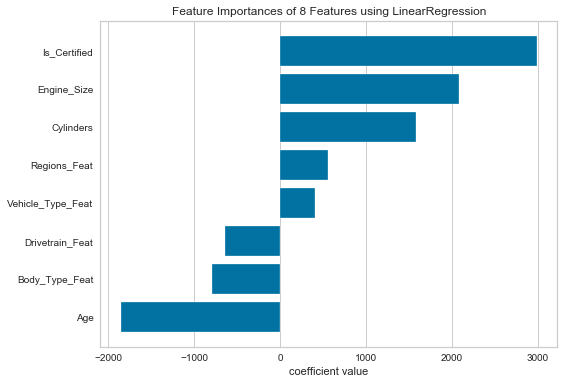

In [37]:
from yellowbrick.features.importances import FeatureImportances
# Create a new figure
fig = plt.figure()
ax = fig.add_subplot()

# Title case the feature for better display and create the visualizer
labels = list(map(lambda s: s.title(), X))
viz = FeatureImportances(LinearRegression(normalize=True), ax=ax, labels=labels, relative=False)

# Fit and show the feature importances
viz.fit(X, y)
viz.poof()

C:\Users\yexin\Anaconda3\envs\myenv\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



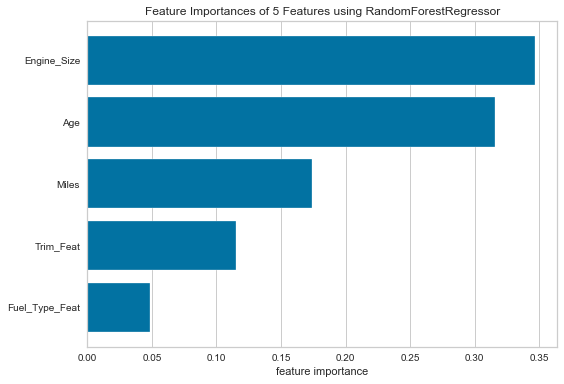

In [38]:
# feature Importance of RandomForestRegressor 

X = labeled[['miles', 'engine_size', 'AGE', 'trim_feat', 'fuel_type_feat']]

from yellowbrick.features.importances import FeatureImportances
# Create a new figure
fig = plt.figure()
ax = fig.add_subplot()

# Title case the feature for better display and create the visualizer
labels = list(map(lambda s: s.title(), X))
viz = FeatureImportances(RandomForestRegressor(), ax=ax, labels=labels, relative=False)

# Fit and show the feature importances
viz.fit(X, y)
viz.poof()

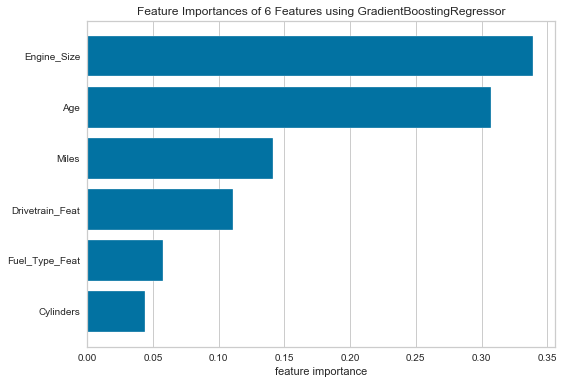

In [39]:
# feature importance for GradientBoostingRegressor
X = labeled[['miles', 'cylinders', 'engine_size', 'AGE', 'fuel_type_feat', 'drivetrain_feat']]
from yellowbrick.features.importances import FeatureImportances
# Create a new figure
fig = plt.figure()
ax = fig.add_subplot()

# Title case the feature for better display and create the visualizer
labels = list(map(lambda s: s.title(), X))
viz = FeatureImportances(GradientBoostingRegressor(), ax=ax, labels=labels, relative=False)

# Fit and show the feature importances
viz.fit(X, y)
viz.poof()

# Modeling with new selected features

## Model 1 Linear Regression

In [40]:
y = labeled['price']
X = labeled[['cylinders', 'is_certified', 'engine_size', 'AGE', 'Regions_feat', 'vehicle_type_feat', 'body_type_feat', 'drivetrain_feat']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [42]:
r2= r2_score(y_pred, y_test)
print(r2)

0.3697466343017962


In [43]:
mean_squared_error(y_pred, y_test)

32024472.820691444

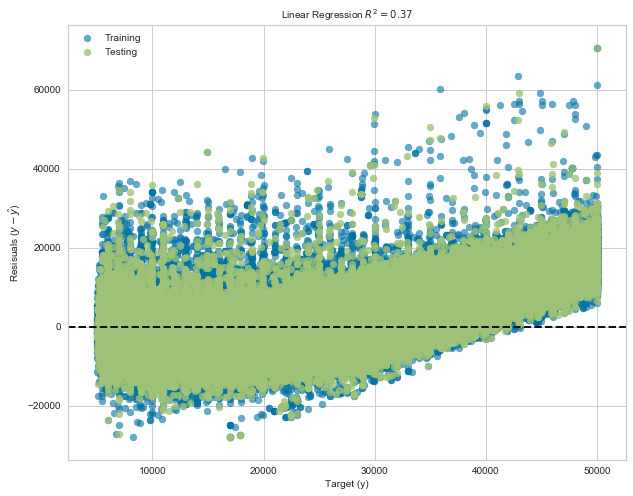

In [44]:
#Compute Residuals
test_residuals = y_test - y_pred
train_residuals = y_train - reg.predict(X_train)

#Draw residuals
fig, ax = plt.subplots(figsize= (10,8))
ax.scatter(y_train, train_residuals, label="Training", alpha=0.6)
ax.scatter(y_test, test_residuals, label="Testing", alpha=0.8)

#Make plot pretty
ax.set_title("Linear Regression $R^2={:0.2f}$".format(r2), fontsize=10)
ax.legend(loc='best', fontsize=10)
ax.set_ylabel("Resisuals ($y-\hat{y}$)", fontsize=10)
ax.set_xlabel("Target (y)", fontsize=10)

#Draw zero line
ax.axhline(0, c='k', ls='--', lw=2)

In [50]:
from yellowbrick.model_selection import CVScores
from sklearn.model_selection import StratifiedKFold

In [ ]:
# Cross Validation
# Create a new figure and axes
_, ax = plt.subplots()

# Create a cross-validation strategy
cv = StratifiedKFold(12)

# Create the cv score visualizer
oz = CVScores(
    GradientBoostingRegressor(), ax=ax, cv=cv, scoring='r2'
)

oz.fit(X, y)
oz.poof()

C:\Users\yexin\Anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:652: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=12.



## Model 2 - Decision Tree (Random Forest Regressor)


In [50]:
y = labeled['price']
X = labeled[['miles', 'engine_size', 'AGE', 'trim_feat', 'fuel_type_feat']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
rf = RandomForestRegressor()

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

C:\Users\yexin\Anaconda3\envs\myenv\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



In [47]:
r2 = r2_score(y_pred, y_test)
print(r2)

0.8031267106600641


In [48]:
mean_squared_error(y_pred, y_test)

13604831.327199323

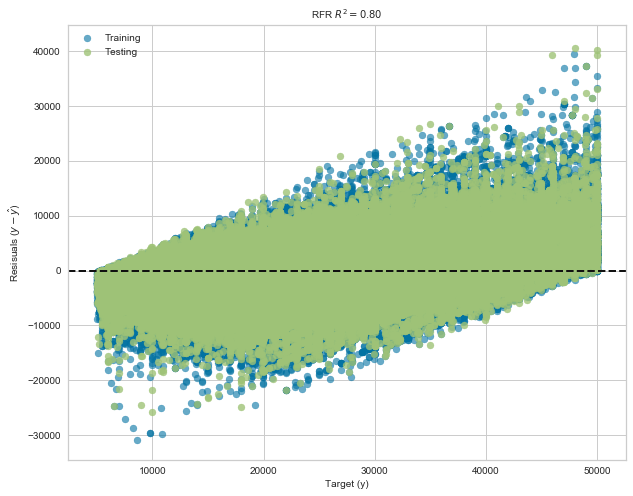

In [49]:
#Compute Residuals
test_residuals = y_test - y_pred
train_residuals = y_train - rf.predict(X_train)

#Draw residuals
fig, ax = plt.subplots(figsize= (10,8))
ax.scatter(y_train, train_residuals, label="Training", alpha=0.6)
ax.scatter(y_test, test_residuals, label="Testing", alpha=0.8)

#Make plot pretty
ax.set_title("RFR $R^2={:0.2f}$".format(r2), fontsize=10)
ax.legend(loc='best', fontsize=10)
ax.set_ylabel("Resisuals ($y-\hat{y}$)", fontsize=10)
ax.set_xlabel("Target (y)", fontsize=10)

#Draw zero line
ax.axhline(0, c='k', ls='--', lw=2)

In [ ]:
# Cross Validation
# Create a new figure and axes
_, ax = plt.subplots()

# Create a cross-validation strategy
cv = StratifiedKFold(12)

# Create the cv score visualizer
oz = CVScores(
    RandomForestRegressor(), ax=ax, cv=cv, scoring='r2'
)

oz.fit(X, y)
oz.poof()

## Model 3 - Decision Tree (Gradient Boost)

In [52]:
y = labeled['price']
X = labeled[['miles', 'cylinders', 'engine_size', 'AGE', 'fuel_type_feat', 'drivetrain_feat']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
gbr = GradientBoostingRegressor()

gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)


In [54]:
r2 = r2_score(y_pred, y_test)
print(r2)

0.7524047170837892


In [55]:
mean_squared_error(y_pred, y_test)

15568912.083164532

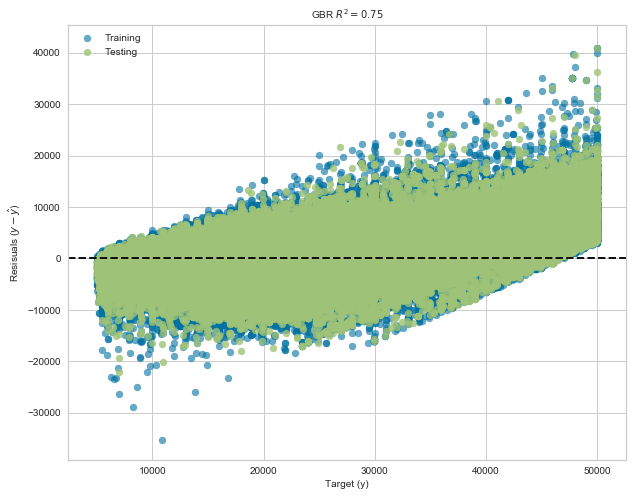

In [56]:
#Compute Residuals
test_residuals = y_test - y_pred
train_residuals = y_train - gbr.predict(X_train)

#Draw residuals
fig, ax = plt.subplots(figsize= (10,8))
ax.scatter(y_train, train_residuals, label="Training", alpha=0.6)
ax.scatter(y_test, test_residuals, label="Testing", alpha=0.8)

#Make plot pretty
ax.set_title("GBR $R^2={:0.2f}$".format(r2), fontsize=10)
ax.legend(loc='best', fontsize=10)
ax.set_ylabel("Resisuals ($y-\hat{y}$)", fontsize=10)
ax.set_xlabel("Target (y)", fontsize=10)

#Draw zero line
ax.axhline(0, c='k', ls='--', lw=2)